# Convolutional Autoencoder on MNIST dataset

**Learning Objective**
1. Build an autoencoder architecture (consisting of an encoder and decoder) in Keras
2. Define the loss using the reconstructive error
3. Define a training step for the autoencoder using tf.GradientTape()
4. Train the autoencoder on the MNIST dataset

## Introduction
This notebook demonstrates how to build and train a convolutional autoencoder.

Autoencoders consist of two models: an encoder and a decoder.

<img src="../assets/autoencoder2.png" width="600">

In this notebook we'll build an autoencoder to recreate MNIST digits. This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 100 epochs. The images increasingly resemble hand written digits as the autoencoder learns to reconstruct the original images.

<img src="../assets/autoencoder.gif">

## Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function

import glob
import imageio
import os
import PIL
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from IPython import display

Next, we'll define some of the environment variables we'll use in this notebook. Note that we are setting the `EMBED_DIM` to be 64. This is the dimension of the latent space for our autoencoder. 

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
BATCH_SIZE = 128
BUFFER_SIZE = 60000
EPOCHS = 60
LR = 1e-2
EMBED_DIM = 64 # intermediate_dim

## Load and prepare the dataset

For this notebook, we will use the MNIST dataset to train the autoencoder. The encoder will map the handwritten digits into the latent space, to force a lower dimensional representation and the decoder will then map the encoding back.

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

Next, we define our input pipeline using `tf.data`. The pipeline below reads in `train_images` as tensor slices and then shuffles and batches the examples for training.

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BATCH_SIZE*4)

In [6]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

## Create the encoder and decoder models

Both our encoder and decoder models will be defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Encoder

The encoder uses [`tf.keras.layers.Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers to map the image into a lower-dimensional latent space. We will start with an image of size 28x28x1 and then use convolution layers to map into a final `Dense` layer.

**Exercise.** Complete the code below to create the CNN-based encoder model. Your model should have `input_shape` to be 28x28x1 and end with a final `Dense` layer the size of `embed_dim`. 

In [7]:
#TODO 1.
def make_encoder(embed_dim):
    model = tf.keras.Sequential(name="encoder")

    # TODO: Your code goes here.
    
    assert model.output_shape == (None, embed_dim)
    
    return model

### The Decoder

The decoder uses [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (upsampling) layers to produce an image from the latent space. We will start with a `Dense` layer with the same input shape as `embed_dim`, then upsample several times until you reach the desired image size of 28x28x1.

**Exercise.** Complete the code below to create the decoder model. Start with a `Dense` layer that takes as input a tensor of size `embed_dim`. Use `tf.keras.layers.Conv2DTranspose` over multiple layers to upsample so that the final layer has shape 28x28x1 (the shape of our original MNIST digits).

Hint: Experiment with using `BatchNormalization` or different activation functions like `LeakyReLU`.

In [8]:
#TODO 1.
def make_decoder(embed_dim):
    model = tf.keras.Sequential(name="decoder")

    # TODO: Your code goes here.
    
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

Finally, we stitch the encoder and decoder models together to create our autoencoder. 

In [9]:
ae_model = tf.keras.models.Sequential([make_encoder(EMBED_DIM), make_decoder(EMBED_DIM)])

Using `.summary()` we can have a high-level summary of the full autoencoder model as well as the individual encoder and decoder. Note how the shapes of the tensors mirror each other as data is passed through the encoder and then the decoder.

In [10]:
ae_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 64)                608064    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         1047360   
Total params: 1,655,424
Trainable params: 1,642,496
Non-trainable params: 12,928
_________________________________________________________________


In [11]:
make_encoder(EMBED_DIM).summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0   

In [12]:
make_decoder(EMBED_DIM).summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4096      
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              401408    
_________________________________________________________________
batch_normalization_3 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512 

Next, we define the loss for our autoencoder model. The loss we will use is the reconstruction error. This loss is similar to the MSE loss we've commonly use for regression. Here we are applying this error pixel-wise to compare the original MNIST image and the image reconstructed from the decoder. 

In [13]:
#TODO 2.
def loss(model, original):
    reconstruction_error = # TODO: Your code goes here.
    return reconstruction_error

### Optimizer for the autoencoder

Next we define the optimizer for model, specifying the learning rate.

In [14]:
optimizer = tf.keras.optimizers.SGD(lr=LR)

### Save checkpoints

This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [15]:
checkpoint_dir = "./ae_training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=ae_model)

## Define the training loop

Next, we define the training loop for training our autoencoder. The train step will use `tf.GradientTape()` to keep track of gradient steps through training.

**Exercise.**
Complete the code below to define the training loop for our autoencoder. Notice the use of `tf.function` below. This annotation causes the function `train_step` to be "compiled". The `train_step` function takes as input a batch of images and passes them through the `ae_model`. The gradient is then computed on the loss against the `ae_model` output and the original image. In the code below, you should
- define `ae_gradients`. This is the gradient of the autoencoder loss with respect to the variables of the `ae_model`.
- create the `gradient_variables` by assigning each ae_gradient computed above to it's respective training variable.
- apply the gradient step using the `optimizer`

In [16]:
#TODO 3.
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        ae_gradients = # TODO: Your code goes here.

    gradient_variables = # TODO: Your code goes here.
    
    # TODO: Your code goes here.

We use the `train_step` function above to define training of our autoencoder. Note here, the `train` function takes as argument the `tf.data` dataset and the number of epochs for training.

In [17]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(ae_model,
                                 epoch + 1,
                                 test_images[:16, :, :, :])

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(ae_model,
                             epochs,
                             test_images[:16, :, :, :])

**Generate and save images.**
We'll use a small helper function to generate images and save them. 

In [18]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pixels = predictions[i, :, :] * 127.5 + 127.5
        pixels = np.array(pixels, dtype='float')
        pixels = pixels.reshape((28,28))
        plt.imshow(pixels, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Let's see how our model performs before any training. We'll take as input the first 16 digits of the MNIST test set. Right now they just look like random noise. 

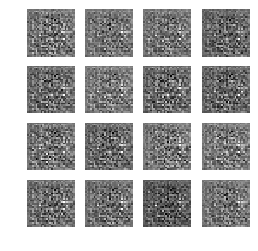

In [19]:
generate_and_save_images(ae_model, 4, test_images[:16, :, :, :])

## Train the model
Call the `train()` method defined above to train the autoencoder model.

We'll print the resulting images as training progresses. At the beginning of the training, the decoded images look like random noise. As training progresses, the model outputs will look increasingly better. After about 50 epochs, they resemble MNIST digits. This may take about one or two minutes / epoch

In [ ]:
#TODO 4.
# TODO: Your code goes here.

## Create a GIF

Lastly, we'll create a gif that shows the progression of our produced images through training. 

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('./ae_images/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'autoencoder.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./ae_images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License